## Bike Index Seattle - Data Prep

### Data cleaning for Seattle streets data, Pt2

##### Objective: Recreate the study by Allen-Munley et al. (2004) for Seattle using WSDOT crash data.


#### Part 3.

I will take traffic volume data from [SDOT](https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::2018-traffic-flow-counts/about), which contain the following [attributes](https://drive.google.com/file/d/1H-ooaihoawm8zXjZz_-AhBmwyRiT1FWQ/view). This is the volume data from 2018, which is the latest and most complete. [2016 Volume](https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::2016-traffic-flow-counts/about) ([metadata](https://www.seattle.gov/Documents/Departments/SDOT/GIS/2016_Traffic_Flow_Counts_OD.pdf)) and [2017 Volume](https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::2017-traffic-flow-counts/about) ([metadata](https://drive.google.com/file/d/1GEuTEN-oPdtu5zesU1XJKubNt2RX2Lwj/view)) are available but less complete, and 2019 and 2020 volume data is not (yet?) available.


Similar to the street data attributes, I will take the coordinate data and project to the street/line data, and replot the point on the nearest line segment.  

Finally, I will merge the street/crash data with volume/crash data, to finalize the data prep to get the attributes needed to recreate the study.

In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point, LineString

import requests
import json

import matplotlib.pyplot as plt

from point_line_snap import SnapLinePoint

In [2]:
%matplotlib inline

#### Step 1: Load data

- Load crash/streets merged data (from Crash Prep and Street Prep Part2)
- Load volume data from SDOT
- Convert to GDF

In [3]:
# From Streets Prep

crashes_merged = pd.read_csv('data/crash_streets.csv', parse_dates=['DATETIME'])

In [4]:
# From Crash Data Prep

crashes = pd.read_csv('data/bike_crash.csv', parse_dates=['DATETIME'])

<AxesSubplot:xlabel='DATETIME'>

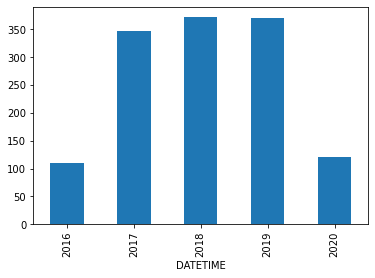

In [5]:
# Distribution of crashes by year- what vehicle volume data to use?

crashes_merged['line_i'].groupby(crashes_merged.DATETIME.dt.year).count().plot(kind='bar')

In [6]:
# Helper function

def get_gdf(url):
    
    r = requests.get(url)
    json = r.json()
    
    return gpd.GeoDataFrame.from_features(json['features'])

In [7]:
# No volume data for 2019 or 2020 available as of Jul 2021

url_2016 = 'https://opendata.arcgis.com/datasets/170b764c52f34c9497720c0463f3b58b_9.geojson'
url_2017 = 'https://opendata.arcgis.com/datasets/2c37babc94d64bbb938a9b520bc5538c_10.geojson'
url_2018 = 'https://opendata.arcgis.com/datasets/a35aa9249110472ba2c69cc574eff984_11.geojson'

In [8]:
# Get GDF from json

vol_2016 = get_gdf(url_2016)
vol_2017 = get_gdf(url_2017)
vol_2018 = get_gdf(url_2018)

Use 2018 volume data as proxy for all crashes- 
- 2019, 2020 data is not (yet?) available
- 2018 is more complete compared to 2016 and 2017

In [9]:
print('vol_2016.shape ',vol_2016.shape)
print('vol_2017.shape ',vol_2017.shape)
print('vol_2018.shape ',vol_2018.shape)

vol_2016.shape  (1865, 15)
vol_2017.shape  (1876, 15)
vol_2018.shape  (1906, 15)


In [10]:
# Use 2018 volume data

volume = vol_2018

In [11]:
volume.columns

Index(['geometry', 'OBJECTID', 'COMPKEY', 'STNAME_ORD', 'FLOWSEGID',
       'DOWNTOWN', 'START_DATE', 'AMPK', 'PMPK', 'AWDT', 'ADT', 'AWDT_ROUNDED',
       'DATAQUALITY', 'FLAGS', 'SHAPE_Length'],
      dtype='object')

In [12]:
# Convert to GDF

keep_cols = ['geometry',
            'STNAME_ORD',
            'AWDT',
            'ADT',
            'AWDT_ROUNDED',
            'SHAPE_Length']

vol_gdf = gpd.GeoDataFrame(volume[keep_cols], geometry='geometry')

In [13]:
vol_gdf.head()

,geometry,STNAME_ORD,AWDT,ADT,AWDT_ROUNDED,SHAPE_Length
0,"LINESTRING (-122.33315 47.61306, -122.33204 47...",PINE ST,8000.0,NaN,8000,322.037238
1,"LINESTRING (-122.37523 47.65358, -122.37539 47...",15TH AVE W ON RP,11129.0,10139.0,11100,173.612269
2,"MULTILINESTRING ((-122.30381 47.67578, -122.30...",NE 65TH ST,20487.0,19740.0,20500,1445.416389
3,"MULTILINESTRING ((-122.41212 47.65410, -122.41...",W EMERSON ST,1007.0,1090.0,1000,999.190937
4,"MULTILINESTRING ((-122.28080 47.52610, -122.28...",S CLOVERDALE ST,4868.0,4615.0,4900,2077.434844


In [14]:
# Load crash data, convert to GDF

geom = [Point(xy) for xy in zip(crashes.LONGITUDE, crashes.LATITUDE)]

crashes_gdf = gpd.GeoDataFrame(crashes.drop(['LATITUDE','LONGITUDE'], axis = 1),
                               geometry = geom)

#### Step 2: Find volume segment corresponding to point data


- Repeat the snap-point-line exercise from Street Data Prep, this time snapping the crash coordinates to the volume street data

In [15]:
# Initiate SLP class, using same offset param as last step

offset = 10**-4 # approx 10m

slp = SnapLinePoint(crashes_gdf, vol_gdf, offset)

In [28]:
vol_merged = slp.snap_to_line()

vol_merged.columns

Index(['line_i', 'line_geo', 'STNAME_ORD', 'AWDT', 'ADT', 'AWDT_ROUNDED',
       'SHAPE_Length', 'REPORT NUMBER', 'PRIMARY TRAFFICWAY',
       'INTERSECTING TRAFFICWAY', 'DATETIME', 'is_dry', 'is_light', 'is_clear',
       'is_hit_run', 'is_workzone', 'is_child', 'impaired', 'speeding',
       'driver_16_25', 'driver_65_plus', 'severity', 'point', 'snap_dist',
       'geometry'],
      dtype='object')

In [31]:
# Some coordinates are dropped because they were not present in volume data- revisit SLP class to keep coordinates? TODO


print('crashes_merged[REPORT NUMBER].shape: ', crashes_merged['REPORT NUMBER'].shape)
print('vol_merged.shape: ', vol_merged.shape)

crashes_merged[REPORT NUMBER].shape:  (1320,)
vol_merged.shape:  (1169, 25)


#### Step 3: Merge new volume data with crash/street data from previous step

In [32]:
select_cols = ['AWDT','ADT','AWDT_ROUNDED','REPORT NUMBER','vol_geo']

vol_select = vol_merged.rename(columns={'line_geo':'vol_geo'})[select_cols]

In [33]:
gdf = vol_select.merge(crashes_merged, on='REPORT NUMBER')

gdf.head()

,AWDT,ADT,AWDT_ROUNDED,REPORT NUMBER,vol_geo,line_i,DATETIME,geometry,line_geo,SPEEDLIMIT,...,is_light,is_clear,is_hit_run,is_workzone,is_child,impaired,speeding,driver_16_25,driver_65_plus,severity
0,6551.0,6058.0,6700,3773772,"MULTILINESTRING ((-122.31811 47.60621, -122.31...",5040.0,2019-04-19 15:52:00,POINT (-122.3194157932671 47.60620717409615),"LINESTRING (-122.3194130473 47.60520171290543,...",20.0,...,1,0,0,0,0,0,0,0,0,3
1,11001.0,10581.0,11300,3773784,"MULTILINESTRING ((-122.32023 47.62546, -122.32...",5053.0,2017-06-27 06:40:00,POINT (-122.320220950092 47.62656256721589),LINESTRING (-122.320226408124 47.6254609770248...,25.0,...,1,0,0,0,0,0,0,0,0,3
2,18147.0,16962.0,18100,E779051,"MULTILINESTRING ((-122.32007 47.63840, -122.32...",22.0,2018-03-10 23:00:00,POINT (-122.3200693522767 47.63866711037208),LINESTRING (-122.3200712955947 47.638403224769...,25.0,...,0,0,1,0,0,0,0,0,0,3
3,13771.0,12966.0,13800,3773767,"MULTILINESTRING ((-122.32021 47.62867, -122.32...",21776.0,2017-07-02 15:13:00,POINT (-122.3200853721749 47.6364851511106),LINESTRING (-122.3200894771424 47.635912816973...,25.0,...,1,0,0,0,0,0,0,0,0,3
4,13771.0,12966.0,13800,3814426,"MULTILINESTRING ((-122.32021 47.62867, -122.32...",14741.0,2018-10-23 21:24:00,POINT (-122.3200713729534 47.63839277947622),LINESTRING (-122.3200798231693 47.637251797263...,25.0,...,0,0,0,0,0,0,0,0,0,2


In [34]:
gdf.columns

Index(['AWDT', 'ADT', 'AWDT_ROUNDED', 'REPORT NUMBER', 'vol_geo', 'line_i',
       'DATETIME', 'geometry', 'line_geo', 'SPEEDLIMIT', 'SURFACEWIDTH',
       'one_way', 'is_steep', 'is_paved', 'is_hwy', 'is_bus', 'is_truck',
       'is_light', 'is_clear', 'is_hit_run', 'is_workzone', 'is_child',
       'impaired', 'speeding', 'driver_16_25', 'driver_65_plus', 'severity'],
      dtype='object')

In [35]:
# Verify shape

gdf.shape

(1169, 27)

In [36]:
# Write to csv

gdf.to_csv('data/crash_streets_vol.csv', index=False)